In [1]:
# import libraries
import numpy as np
import rasterio
from datetime import datetime
from time import perf_counter

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib

# path to ffmpeg for creating more efficiently encoded videos
matplotlib.rcParams['animation.ffmpeg_path'] = r'C:\\Users\\dd\\.conda\\envs\\ML_in_geosciences\\ffmpeg\\bin\\ffmpeg.exe'

In [2]:
# create colormap to use for plotting ndfi
colors = [ "lawngreen", "white", "darkorange"]
nodes = [0., .5, 1.]
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list("cmap_ndfi", list(zip(nodes, colors)))

In [3]:
def band_name_to_doy(in_str):
    date = datetime.strptime(in_str[5:], '%Y%m%d')
    doy = datetime.strftime(date, '%j')
    return int(doy)

def doy_to_date(doy):
    date = datetime.strptime(f'2018{str(doy)}', '%Y%j')
    out_str = datetime.strftime(date, '%d. %m. %Y')
    return out_str

In [4]:
def load_dataset(inpath):
    """Load raster and convert it into numpy array with values between -1 and 1."""
    with rasterio.open(inpath, 'r') as raster:
        loaded_data = raster.read()
        band_names = raster.descriptions
    
    loaded_data = np.array(loaded_data, np.float16)
    loaded_data = loaded_data / 10_000
    loaded_data[loaded_data<-3] = np.nan
    loaded_data[loaded_data<-1] = -1
    loaded_data[loaded_data>1] = 1
    
    doys = tuple(band_name_to_doy(i) for i in band_names)

    print(loaded_data.shape)
    return loaded_data, doys

def load_basemap(inpath):
    with rasterio.open(inpath, 'r') as raster:
        loaded_data = raster.read()
    loaded_data = np.moveaxis(loaded_data, 0, 2)
    return loaded_data

path_branden = 'E:/__Earth_Observation/grasslands/data/raster/ndfi/ndfi_branden.tif'
path_nordsea = 'E:/__Earth_Observation/grasslands/data/raster/ndfi/ndfi_nordsea.tif'
path_allgaeu = 'E:/__Earth_Observation/grasslands/data/raster/ndfi/ndfi_allgaeu.tif'

a = perf_counter()
data_1, doys_1 = load_dataset(path_branden)
data_2, doys_2 = load_dataset(path_nordsea)
data_3, doys_3 = load_dataset(path_allgaeu)
print(f'Loading the NDFI rasters took {perf_counter()-a} seconds.')

doy_min = min(doys_1[0],  doys_2[0],  doys_3[0])
doy_max = max(doys_1[-1], doys_2[-1], doys_3[-1])
days = int(doy_max) - int(doy_min)

(46, 3000, 3000)
(52, 3000, 3000)
(51, 3000, 3000)
Loading the NDFI rasters took 30.203556900000002 seconds.


In [5]:
def subplot_setup(ax, img_background, img_first, title):
    """Sets up individual subplots with the first frame and plot styling."""
    # show background of first frame
    ax.imshow(img_background)
    # show first observation
    img = ax.imshow(img_first, cmap=CMAP, vmin=-1, vmax=1)
    
    # style the subplot
    ax.set_axis_off()
    ax.set_title(title)
    
    return img

In [6]:
def animate(i, *args):
    doy_min = int(min(args[3][0], args[4][0], args[5][0]))
    doy = i + doy_min
    print(doy)

    if doy in args[3]:
        img_1.set_data(args[0][args[3].index(doy),:,:])
    if doy in args[4]:
        img_2.set_data(args[1][args[4].index(doy),:,:])
    if doy in args[5]:
        img_3.set_data(args[2][args[5].index(doy),:,:])
    
    fig.texts[1].set_text(f'DOY: {doy}')
    fig.texts[2].set_text(f'Date: {doy_to_date(doy)}')

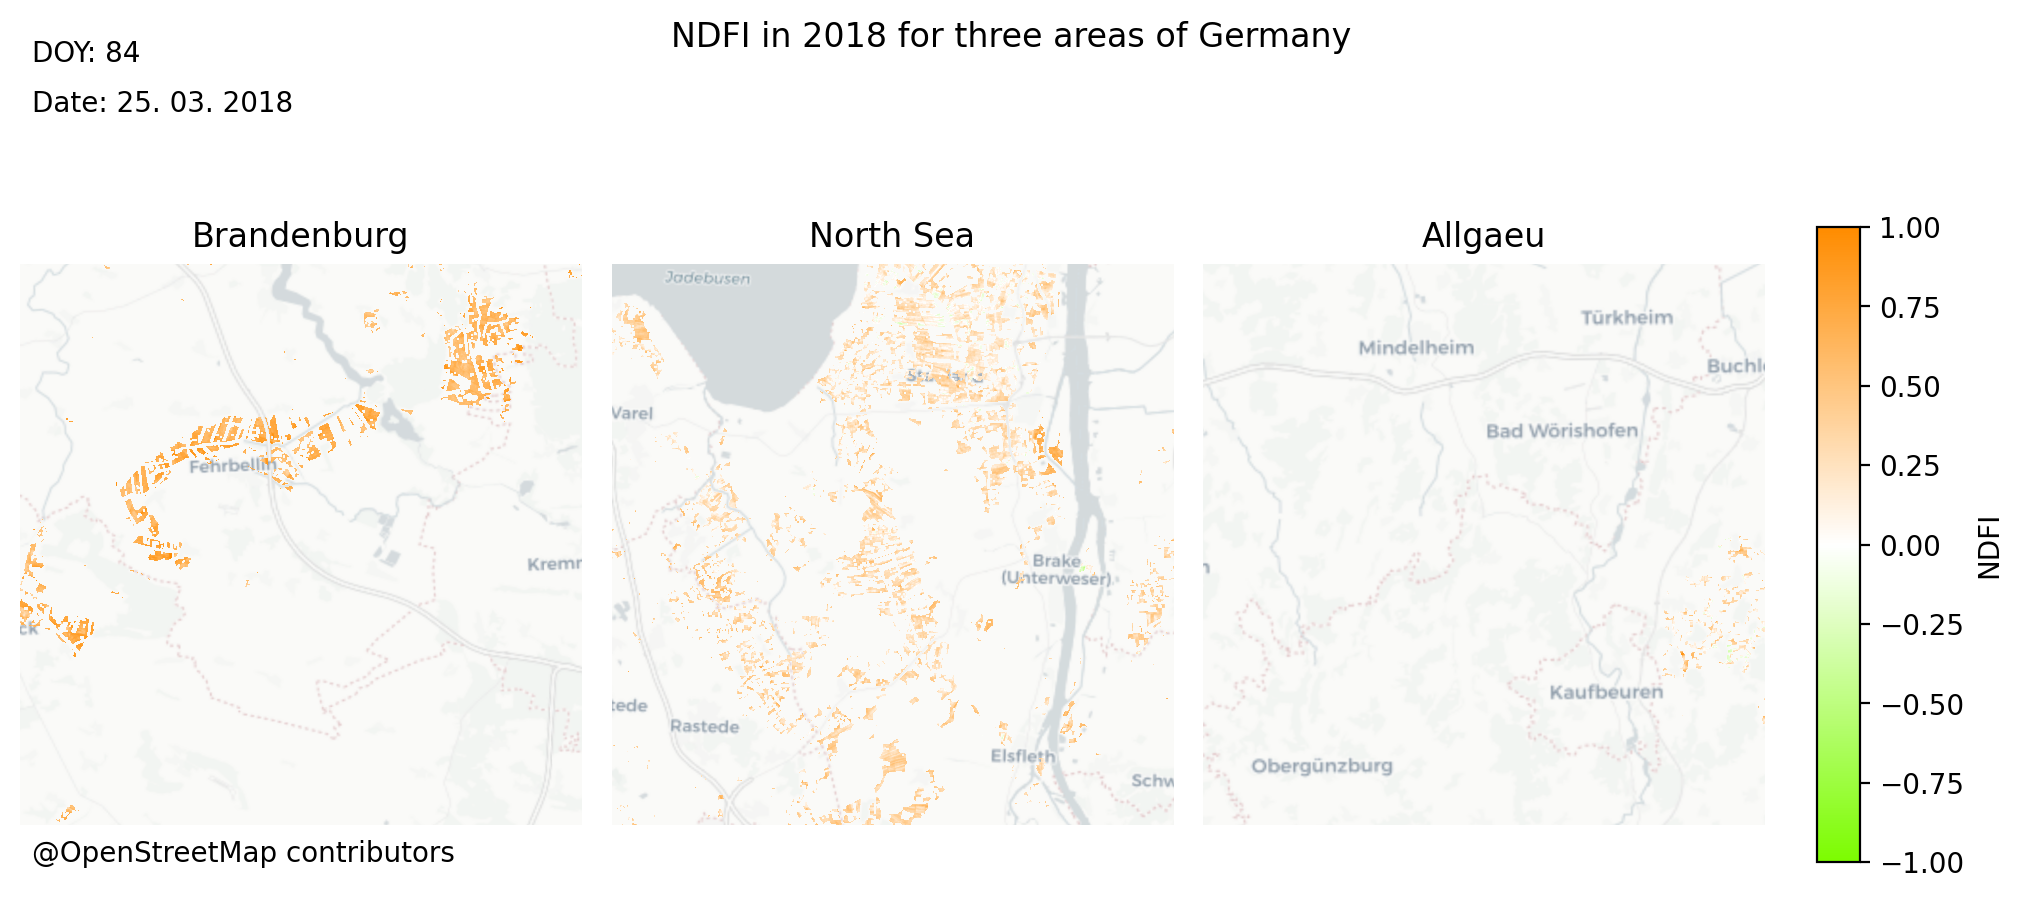

In [7]:
# create figure and style it
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 5), dpi=200., constrained_layout=True)
fig.suptitle('NDFI in 2018 for three areas of Germany')
fig.text(.01, .95, f'DOY: {str(int(doy_min))}')
fig.text(.01, .90, f'Date: {doy_to_date(doy_min)}')
fig.text(.01, .15, f'@OpenStreetMap contributors')

# set up individual subplots
# first subplot returns a Mappable which is used for creating the colorbar
test_background = np.random.rand(3000,3000)
basemap_branden = load_basemap('E:/__Earth_Observation/grasslands/data/raster/basemap_branden.tif')
basemap_nordsea = load_basemap('E:/__Earth_Observation/grasslands/data/raster/basemap_nordsea.tif')
basemap_allgaeu = load_basemap('E:/__Earth_Observation/grasslands/data/raster/basemap_allgaeu.tif')

img_1 = subplot_setup(ax1, basemap_branden, data_1[0,:,:], 'Brandenburg')
img_2 = subplot_setup(ax2, basemap_nordsea, data_2[0,:,:], 'North Sea')
img_3 = subplot_setup(ax3, basemap_allgaeu, data_3[0,:,:], 'Allgaeu')

# create colorbar
cbar = plt.colorbar(img_1, ax=[ax1, ax2, ax3], shrink=0.68)
cbar.set_label('NDFI')

anim_args = (data_1, data_2, data_3, doys_1, doys_2, doys_3)

# animate the figure
ani = animation.FuncAnimation(fig, animate, frames=days, fargs=anim_args,
                              interval=125)

In [8]:
# To save the animation, use e.g.
writer = animation.FFMpegWriter(fps=8, metadata=dict(artist='Me'))#, bitrate=1800)

print(f'Processing days of the year between {doy_min} and {doy_max}')
a = perf_counter()
ani.save('E:/__Earth_Observation/grasslands/data/raster/ndfi_anim_test_25.mp4', writer=writer)
print(f'Saving the animation took {perf_counter()-a} seconds.')

Processing days of the year between 84 and 320
84
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
Saving the animation t

In [9]:
#html_str = f'{ani.to_html5_video()}'